In [4]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

def get_preprocessed_data(images, targets):
    images = np.array(images / 255.0, dtype=np.float32)
    targets = np.array(targets, dtype=np.float32)
    
    return images, targets

def get_preprocessed_ohe(images, targets):
    images, targets = get_preprocessed_data(images, targets)
    oh_targets = to_categorical(targets)
    return images, oh_targets

def get_train_valid_test(train_images, train_targets, test_images, test_targets, validation_size=0.2, random_state=124):
    train_images, train_oh_targets = get_preprocessed_ohe(train_images, train_targets)
    test_images, test_oh_targets = get_preprocessed_ohe(test_images, test_targets)
    
    train_images, validation_images, train_oh_targets, validation_oh_targets = \
    train_test_split(train_images, train_oh_targets, stratify=train_oh_targets, test_size=validation_size, random_state=random_state)
    
    return (train_images, train_oh_targets), (validation_images, validation_oh_targets), (test_images, test_oh_targets)

In [5]:
from tensorflow.keras.datasets import mnist

(train_images, train_targets), (test_images, test_targets) = mnist.load_data()

(train_images, train_oh_targets), (validation_images, validation_oh_targets), (test_images, test_oh_targets) = \
get_train_valid_test(train_images, train_targets, test_images, test_targets)

print(train_images.shape, train_oh_targets.shape)
print(validation_images.shape, validation_oh_targets.shape)
print(test_images.shape, test_oh_targets.shape)

(48000, 28, 28) (48000, 10)
(12000, 28, 28) (12000, 10)
(10000, 28, 28) (10000, 10)


In [7]:
from tensorflow.keras.layers import Layer, Input, Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model

INPUT_SIZE = 28

input_tensor = Input(shape=(INPUT_SIZE, INPUT_SIZE, 1))

x = Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(input_tensor)

x = Conv2D(filters=64, kernel_size=3, activation='relu')(x)

x = Conv2D(filters=128, kernel_size=3, activation='relu')(x)

x = MaxPooling2D(2)(x)

x = Flatten()(x)

x = Dense(64, activation='relu')(x)

output = Dense(10, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=output)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 26, 26, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │       1,179,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,273,034 (4.86 MB)

 Trainable params: 1,273,034 (4.86 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy

model.compile(optimizer=Adam(0.001), loss=CategoricalCrossentropy(), metrics=['acc'])

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

mcp_cb = ModelCheckpoint(
    filepath="./callback_files/weights.{epoch:03d}-{val_loss:.4f}-{acc:.4f}.weights.h5",
    monitor='val_loss',
    # 모든 epoch의 파일을 저장하지 않고 좋은 성능이라 판단될 경우만 저장할 때 True설정
    save_best_only=False,
    save_weights_only=True,
    mode='min'
)

rlr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    mode='min'
)

ely_cb = EarlyStopping(
    monitor='val_loss',
    patience=3,
    mode='min'
)

history = model.fit(x=train_images, 
                    y=train_oh_targets, 
                    batch_size=32, 
                    epochs=20, 
                    validation_data=(validation_images, validation_oh_targets), 
                    validation_split=0.2, 
                    callbacks=[mcp_cb, rlr_cb, ely_cb])

Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 30s 20ms/step - acc: 0.9899 - loss: 0.0312 - val_acc: 0.9876 - val_loss: 0.0412 - learning_rate: 0.0010
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 30s 20ms/step - acc: 0.9930 - loss: 0.0205 - val_acc: 0.9898 - val_loss: 0.0392 - learning_rate: 0.0010
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 29s 20ms/step - acc: 0.9960 - loss: 0.0123 - val_acc: 0.9886 - val_loss: 0.0443 - learning_rate: 0.0010
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - acc: 0.9969 - loss: 0.0099 - val_acc: 0.9897 - val_loss: 0.0485 - learning_rate: 0.0010
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - acc: 0.9991 - loss: 0.0024 - val_acc: 0.9917 - val_loss: 0.0394 - learning_rate: 1.0000e-04


In [13]:
# 테스트 데이터 세트로 모델 성능 검증
model.evaluate(test_images, test_oh_targets, batch_size=32, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - acc: 0.9904 - loss: 0.0398


[0.029509570449590683, 0.9932000041007996]

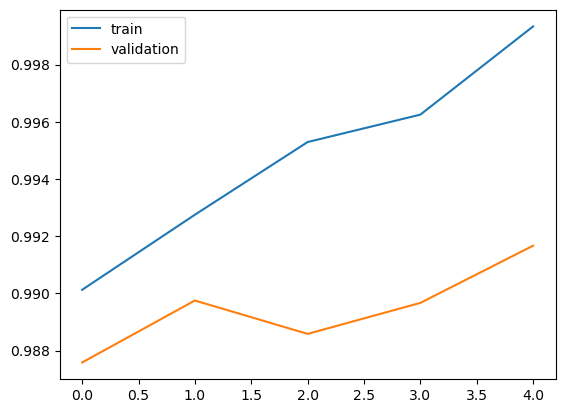

In [14]:
import matplotlib.pyplot as plt

def show_history(history):
    plt.plot(history.history['acc'], label='train')
    plt.plot(history.history['val_acc'], label='validation')
    plt.legend()
    plt.show()

show_history(history)

In [15]:
model.load_weights('./callback_files/weights.005-0.0394-0.9993.weights.h5')

model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=['acc'])

In [16]:
history = model.fit(x=train_images, 
                    y=train_oh_targets, 
                    batch_size=32, 
                    epochs=20, 
                    validation_data=(validation_images, validation_oh_targets), 
                    validation_split=0.2, 
                    callbacks=[mcp_cb, rlr_cb, ely_cb])

Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 32s 20ms/step - acc: 0.9971 - loss: 0.0105 - val_acc: 0.9886 - val_loss: 0.0637 - learning_rate: 0.0010
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - acc: 0.9972 - loss: 0.0092 - val_acc: 0.9896 - val_loss: 0.0515 - learning_rate: 0.0010
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 29s 20ms/step - acc: 0.9987 - loss: 0.0043 - val_acc: 0.9883 - val_loss: 0.0524 - learning_rate: 0.0010
